# Вероятностная оценка запасов методом Монте-Карло

    1. Написание функции расчета запасов STOIIP 

In [1]:
def STOIIP_base(rv, phi, s_oil, b_oil):
    '''
    STOIIP_base - основная функция для расчета запасов s_p
    rv - объем породы, занятой нефтью
    phi - пористость = объем пор / общий объем породы 
    s_oil = (1-s_water) - нефтенасыщенность 

    
    '''
    s_p = (rv*phi*s_oil)/b_oil
    
    return s_p

In [2]:
def STOIIP_det(grv, phi, s_oil, b_oil,ntg): #используем эту
    '''
    STOIIP_det - детерменированная  функция для расчета запасов s_p // наилучшая техническая 
    grv - общий объем породы
    phi - пористость
    s_oil = (1-s_water) - нефтенасыщенность 
    b_oil = rb/stb - коэффициент нефтеобразования > 1 // объемный коэффициент: отношение объема нефти при пластовом
    давлении к объему нефти в стандартных условиях 
    ntg - песчанистость (отношение эффективной проницаемой толщины (коллектора) к общей толщине (коллектор+неколлектор))
    
    '''
    s_p = 7758*(grv*phi*s_oil*ntg)/b_oil
    
    return s_p

    2. Диапазоны неопределённости

Нефтенасыщенность: $ s_{o} \in [0.6, 0.9] $

Объемный коэффициент нефти: $ b_{o} \in [1.2, 1.8] $ 1.2 – 1.8

Пористость $\phi \in [0.05, 0.5] $

Общий объем породы $grv \in [114000000,189750000]$

Песчанистость $ntg \in [0.72,0.94] $

Дополнительно:
Плотность пластовой:  780 – 840 кг/м3

Плотность дегазированной:  840 – 870 кг/м3

Коэффициент сжимаемости: 6-18 *10(-6) МПа(-1)
 
 

In [3]:
import numpy as np 
from scipy. stats import norm
import random
import plotly.graph_objects as go
import warnings
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
batchsize = 500

In [5]:
grv_borders   = [114000000,189750000]
phi_borders = [0.05, 0.5] 
s_oil_borders = [0.6, 0.9]
ntg_borders = [0.72,0.94]
b_oil_borders = [1.1, 1.8]

In [6]:
PARAMS = {
    "phi": phi_borders,
    "s_oil": s_oil_borders,
    "b_oil": b_oil_borders,
    "grv": grv_borders,
    "ntg": ntg_borders
    
}

In [7]:
DATA = {}

In [8]:
for name, param in PARAMS.items():

    mu = (param[1] + param[0])/2
    sigma = (mu - param[0])/4
#     DATA[f'{name}'] = np.random.normal(mu, sigma, batchsize)  - использование другой библиотеки
    DATA[f'{name}'] = norm.rvs(size = batchsize, loc=mu, scale=sigma)

In [9]:
# print(DATA)

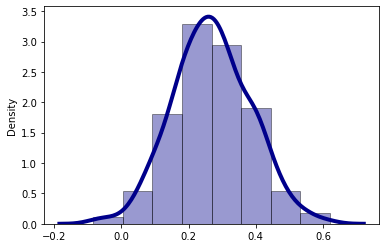

In [10]:
    '''
    Проверка на нормальность распределения

    '''
sns.distplot(DATA['phi'], hist=True, kde=True,
             bins=8, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

    3. Функция для выбора случайного числа из последовательности:

In [11]:
def random_value(set_params):
    '''
    set_params - сгенерированный набор параметров
    value - случайное число из набора 
    '''
    value = random.choice(set_params)
    return value

    4. Применение метода Монте-Карло

In [12]:
N = 4000 

#количество итераций - эмпирическим путем выбрано оптимальное значение 4000


In [13]:
reserve = [] #Создаем пустой список, в который будет добавлять значения запасов
for i in range(N):
    s_p = STOIIP_det(random_value(DATA['grv']), random_value(DATA['phi']), random_value(DATA['s_oil']),
                     random_value(DATA['b_oil']),random_value(DATA['ntg']))
    reserve.append(s_p)

In [14]:
# print(reserve

<AxesSubplot:ylabel='Count'>

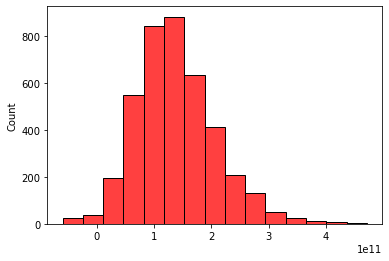

In [16]:
#Построим диаграмму 
sns.histplot(reserve,bins = 15,color='red') 

    5. Построение графика ECDF

4001


[Text(0, 0.5, 'Персентиль'),
 Text(0.5, 0, 'Запасы, $м^{3}$'),
 Text(0.5, 1.0, 'График запасов')]

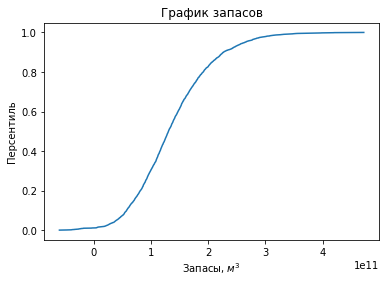

In [17]:
ecdf = sm.distributions.ECDF(reserve) 
print(len(ecdf.x))
sns.lineplot(ecdf.x, ecdf.y).set(ylabel='Персентиль',
 xlabel='Запасы, $м^{3}$',title='График запасов')

Отобразим на графике расположение персентилей

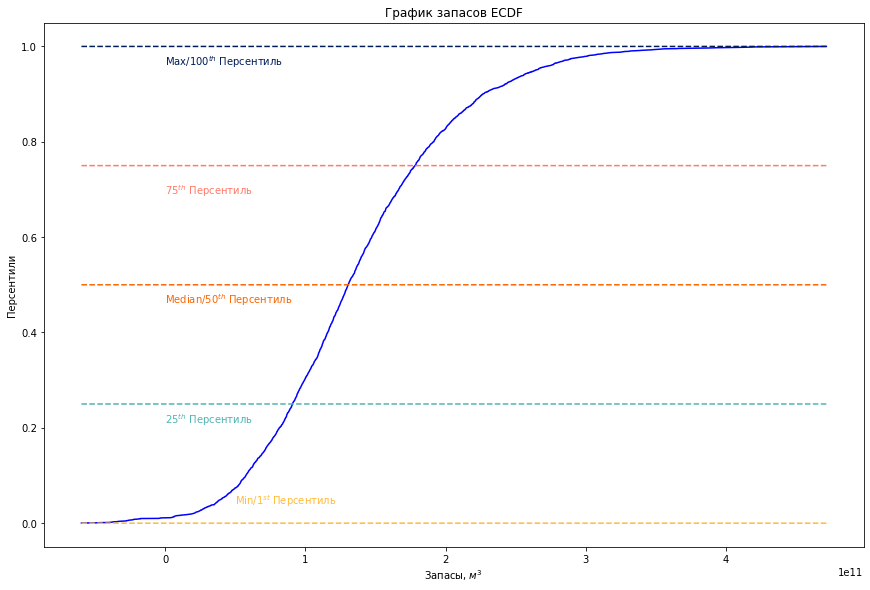

In [18]:
#data preparation for plotting, capturing important statistics 
ymedian = np.empty(len(reserve)+1) 
ymedian.fill(0.5) 
ymax = np.empty(len(reserve)+1) 
ymax.fill(np.max(ecdf.y)) 
ymin = np.empty(len(reserve)+1) 
ymin.fill(np.min(ecdf.y)) 
y25 = np.empty(len(reserve)+1) 
y25.fill(0.25) 
y75 = np.empty(len(reserve)+1) 
y75.fill(0.75) 
fig,ax = plt.subplots(figsize=(12, 8)) 
# Plot the data 
setosa_ecdf = ax.plot(ecdf.x,ecdf.y, label='Data',color = 'blue') 
# Plot the lines 
max_line = ax.plot(ecdf.x,ymax, label='Max', linestyle='--',color = '#001c58') 
y75_line = ax.plot(ecdf.x,y75, label='75Percentile', linestyle='--',color = '#ff7a69') 
med_line = ax.plot(ecdf.x,ymedian, label='Median', linestyle='--',color = '#fb6500') 
y25_line = ax.plot(ecdf.x,y25, label='25Percentile', linestyle='--',color = '#4fb4b1') 
min_line = ax.plot(ecdf.x,ymin, label='Min', linestyle='--',color = '#ffbb39') 
#annotate lines 
ax.annotate('Max/$100^{th}$ Персентиль',xy = (1,0.96),color = '#001c58') 
ax.annotate('$75^{th}$ Персентиль',xy = (1,0.69),color = '#ff7a69') 
ax.annotate('Median/$50^{th}$ Персентиль',xy = (1,0.46),color = '#fb6500') 
ax.annotate('$25^{th}$ Персентиль',xy = (1,0.21),color = '#4fb4b1') 
ax.annotate('Min/$1^{st}$ Персентиль',xy = (0.5e+11,0.04),color = '#ffbb39') 
#final and important bits 
plt.tight_layout() 
plt.title('График запасов ECDF') 
plt.xlabel('Запасы, $м^{3}$') 
plt.ylabel('Персентили') 
plt.show()